In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch
import torch.nn as nn
from transformers import ViTModel
from torchinfo import summary  # 
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
import random
import time

In [2]:

def setAllSeeds(seed):
  os.environ['MY_GLOBAL_SEED'] = str(seed)
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
setAllSeeds(42)

In [3]:
def show_fashionImage(image):
    """Show image with landmarks"""
    plt.imshow(image)

In [4]:
df = pd.read_csv("train.csv")
df = df[df["Category"]=="Men Tshirts"]

In [5]:
delCol = []
idxCol = []
trackNum = []
for i in range(1,11):
    uniName = df["attr_"+str(i)].unique()
    # print(len(uniName))
    if(len(uniName)==1):
        delCol.append("attr_"+str(i))
    else:
        idxCol.append("attr_"+str(i))
        trackNum.append(len(uniName))

In [6]:
delCol

['attr_6', 'attr_7', 'attr_8', 'attr_9', 'attr_10']

In [7]:
df = df.drop(delCol,axis=1)

In [8]:
df = df.fillna("NA")

In [9]:
one_hot_encoded_df = pd.get_dummies(df, columns = idxCol)

In [10]:
class CustomFashionManager(Dataset):
    def __init__(self,csv_file, root_dir="./",transforms =None):
        self.fashionItems = csv_file
        self.root_dir = root_dir
        self.transforms = transforms
    
    def __len__(self):
        return len(self.fashionItems)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                ("0"*(6-len(str(self.fashionItems.iloc[idx, 0])))+str(self.fashionItems.iloc[idx, 0])+".jpg"))
        image = io.imread(img_name)
        attributes = self.fashionItems.iloc[idx, 3:]
        attributes = np.array([attributes])
        attributes = attributes.astype('float')
        # print(attributes.shape)
        # attributes = attributes.astype('float').reshape(-1, len(attributes))
        sample = {'image': image, 'attributes': attributes}

        if self.transforms:
            sample = self.transforms(sample)

        return sample


0 (476, 512, 3) (1, 18)
1 (380, 512, 3) (1, 18)
2 (380, 512, 3) (1, 18)
3 (380, 512, 3) (1, 18)


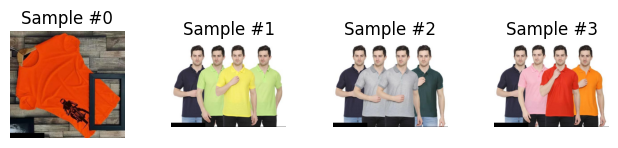

In [11]:
fashion_data = CustomFashionManager(csv_file=one_hot_encoded_df,
                                    root_dir='/notebooks/Men Tshirts')

fig = plt.figure()

for i in range(len(fashion_data)):
    sample = fashion_data[i]

    print(i, sample['image'].shape, sample['attributes'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_fashionImage(sample["image"])

    if i == 3:
        plt.show()
        break

        

In [12]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, attributes= sample['image'], sample["attributes"]

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        # landmarks = landmarks * [new_w / w, new_h / h]

        return {'image': img, "attributes": attributes}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, attributes= sample['image'], sample["attributes"]

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        return {'image': image, "attributes": attributes}



class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, attributes= sample['image'], sample["attributes"]

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
               "attributes":torch.tensor(attributes, dtype=torch.long) }

# class Normalize

In [13]:
import torch

class Normalize(object):
    """Normalize the image in a sample with mean and standard deviation.

    Args:
        mean (list or tuple): Sequence of means for each channel.
        std (list or tuple): Sequence of standard deviations for each channel.
    """
    
    def __init__(self, mean, std):
        self.mean = torch.tensor(mean).view(-1, 1, 1)  # Shape: [C, 1, 1]
        self.std = torch.tensor(std).view(-1, 1, 1)    # Shape: [C, 1, 1]

    def __call__(self, sample):
        image, attributes = sample['image'], sample['attributes']
        
        # Ensure the image is a float tensor
        image = image.float()
        
        # Move mean and std to the same device as image
        self.mean = self.mean.to(image.device)
        self.std = self.std.to(image.device)
        
        # Normalize the image
        image = (image - self.mean) / self.std
        
        return {'image': image,
                'attributes': attributes}


[[0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1.]]
[[0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1.]]
[[0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1.]]


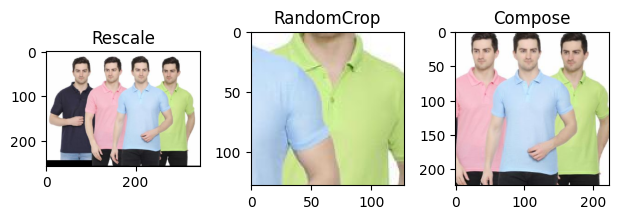

In [14]:
scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256),
                               RandomCrop(224)])
composed2 = transforms.Compose([
                                               Rescale(256),
                                               RandomCrop(224),
                                               ToTensor(),
                                               Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225])])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = fashion_data[65]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)
    print(transformed_sample["attributes"])
    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_fashionImage(transformed_sample["image"])

plt.show()

In [15]:
transformed_dataset = CustomFashionManager(csv_file=one_hot_encoded_df,
                                    root_dir='/notebooks/Men Tshirts',
                                           transforms=transforms.Compose([
                                               Rescale(256),
                                               RandomCrop(224),
                                               ToTensor(),
                                               Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225]),

                                           ]))

for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]

    print(i, sample['image'].size(), sample['attributes'].size())

    if i == 3:
        break

0 torch.Size([3, 224, 224]) torch.Size([1, 18])
1 torch.Size([3, 224, 224]) torch.Size([1, 18])
2 torch.Size([3, 224, 224]) torch.Size([1, 18])
3 torch.Size([3, 224, 224]) torch.Size([1, 18])


In [16]:
# dataloader = DataLoader(transformed_dataset, batch_size=4,
#                         shuffle=True, num_workers=4)


# # Helper function to show a batch
# def show_landmarks_batch(sample_batched):
#     """Show image with landmarks for a batch of samples."""
#     images_batch, landmarks_batch = \
#             sample_batched['image'], sample_batched['attributes']
#     batch_size = len(images_batch)
#     im_size = images_batch.size(2)

#     grid = utils.make_grid(images_batch)
#     plt.imshow(grid.numpy().transpose((1, 2, 0)))

#     for i in range(batch_size):
#         plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size,
#                     landmarks_batch[i, :, 1].numpy(),
#                     s=10, marker='.', c='r')

#         plt.title('Batch from dataloader')

# for i_batch, sample_batched in enumerate(dataloader):
#     print(i_batch, sample_batched['image'].size(),
#           sample_batched['attributes'].size())

#     # observe 4th batch and stop.
#     if i_batch == 3:
#         plt.figure()
#         show_landmarks_batch(sample_batched)
#         plt.axis('off')
#         plt.ioff()
#         plt.show()
#         break

In [17]:
from torch.utils.data import DataLoader, SubsetRandomSampler

# Define indices
indices = list(range(len(transformed_dataset)))
split = int(np.floor(0.7 * len(transformed_dataset)))
np.random.shuffle(indices)

train_indices, val_indices = indices[:split], indices[split:]
val_indices, test_indices = val_indices[:int(len(val_indices)/2)], val_indices[int(len(val_indices)/2):]

# Define samplers
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

# Create DataLoaders
train_loader = DataLoader(transformed_dataset, batch_size=32, sampler=train_sampler, num_workers=4)
val_loader = DataLoader(transformed_dataset, batch_size=32, sampler=val_sampler, num_workers=4)
test_loader = DataLoader(transformed_dataset,batch_size=32,sampler=test_sampler,num_workers=4)

In [18]:

class MultiLabelMultiClassViT(nn.Module):
    def __init__(self, num_labels, num_classes_per_label):
        super(MultiLabelMultiClassViT, self).__init__()
        self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224')  # Load pretrained ViT
        self.num_labels = num_labels
        self.classifiers = nn.ModuleList([
            nn.Linear(self.vit.config.hidden_size, num_classes) 
            for num_classes in num_classes_per_label
        ])  # Create a classifier per label

    def forward(self, x):
        vit_outputs = self.vit(x)
        outputs = vit_outputs.last_hidden_state  # Use only the last hidden state (CLS token representation)
        cls_output = outputs[:, 0, :]  # Extract CLS token
        logits = [classifier(cls_output) for classifier in self.classifiers]  # Get logits for each label's classes
        probs = [(logit) for logit in logits]  # Apply softmax per label
        return probs

# Example usage
num_labels = len(trackNum)  # For example, 5 different labels
model = MultiLabelMultiClassViT(num_labels, trackNum)


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
# for sample in train_loader:
#     print(sample["image"])
#     out = model(sample["image"])
#     break

In [20]:
startIdx = [0]
endIdx = [trackNum[0]]
for i in range(len(trackNum)-1):
    startIdx.append(startIdx[-1]+trackNum[i])
    endIdx.append(endIdx[-1]+trackNum[i+1])

In [21]:
startIdx,endIdx, trackNum

([0, 5, 8, 11, 15], [5, 8, 11, 15, 18], [5, 3, 3, 4, 3])

In [22]:
def computeAccu(model,dataLoader,device,trackNum,startIdx,endIdx):
  model.eval()
  with torch.no_grad():
    correctPred = 0
    totalPred = 0

    for sample in dataLoader:
      features = sample["image"].to(device)
      targets  = sample["attributes"].to(device)

      logits   = model(features)
      for idx in range(len(trackNum)):
          _ , predLabel = torch.max(logits[idx],1)
          newTar = targets[:,:,startIdx[idx]:endIdx[idx]]
          newTar = newTar.reshape(-1,endIdx[idx]-startIdx[idx])
          _ , target = torch.max(newTar,1)
          totalPred += target.size(0)
          correctPred += (predLabel == target).sum()

  return correctPred.float()/totalPred * 100


In [23]:
def modelTrainer(model1, numEpochs, trainLoader,testLoader,valLoader, opt, device,trackNum,startIdx,endIdx,scheduler=None,schedulerOn='validAcc'):
  startTime = time.time()
  miniBatchLoss = []
  trainAccLoss = []
  valAccLoss = []
  valPlotAccLoss =[]
  for e in range(numEpochs):
    model1.train()
    for batchIdx, sample in enumerate(trainLoader):
      features = sample["image"].to(device)
      targets  = sample["attributes"].to(device)
      # print(targets.shape)
      logits = model1(features)
      # _, predLabel = torch.max(logits,1)
      trackcost = None
      # trackcost.to(device)
      for idx in range(len(trackNum)):
          newTar = targets[:,:,startIdx[idx]:endIdx[idx]]
          newTar = newTar.reshape(-1,endIdx[idx]-startIdx[idx])
          _ , newTar = torch.max(newTar,1)
          cost = torch.nn.functional.cross_entropy(logits[idx],newTar)/100
          # print(cost)
          # print(trackcost)
          if(trackcost):
              trackcost+= cost
          else:
              trackcost = cost
      opt.zero_grad()
      trackcost.backward()
      opt.step()
      miniBatchLoss.append(trackcost.item())
      if ( not (batchIdx%50) ):
        print('Epoch:%03d/%03d | Batch:%03d/%03d |  Cost:%.4f' %(e+1, numEpochs, batchIdx, len(trainLoader), cost.item()))
    with torch.no_grad():
      print('Epoch:%03d/%03d |' %(e+1, numEpochs))
      trainLoss = computeAccu(model1, trainLoader,device,trackNum,startIdx,endIdx)
      valLoss   = computeAccu(model1, valLoader  ,device,trackNum,startIdx,endIdx)
      valAccLoss.append(valLoss)
      trainAccLoss.append(trainLoss.cpu().numpy())
      
      print(f'Train Acc {trainLoss :.4f}%')
      print(f'Val Acc   {valLoss:.4f}%')
      print(f'Time Taken: {((time.time()-startTime)/60):.2f} min')
      if(scheduler is not None):
        if(schedulerOn == 'validAcc'):
          scheduler.step(valAccLoss[-1])
        elif(schedulerOn == 'miniBatchLoss'):
          scheduler.step(miniBatchLoss[-1])
        else:
          raise ValueError(f'invalid choice for SchedulerOn {schedulerOn}')
      # valAccLoss[-1] = valLoss.detach().numpy()
      valPlotAccLoss.append(valLoss.cpu().numpy())
#     break
    if(not((e+1)%5)):
        torch.save(model1.state_dict(), f'model{e+1}.pt')
        torch.save(opt.state_dict(), f'optimizer{e+1}.pt')
        torch.save(scheduler.state_dict(), f'schd{e+1}.pt')
  testLoss = computeAccu(model1, testLoader, device,trackNum,startIdx,endIdx)
  print(f'Test Acc   {testLoss:.4f}%')
  print(f'Total Time Taken: {((time.time()-startTime)/60):.2f} min')

  return miniBatchLoss, trainAccLoss, valPlotAccLoss


In [24]:
trackNum,startIdx,endIdx

([5, 3, 3, 4, 3], [0, 5, 8, 11, 15], [5, 8, 11, 15, 18])

In [25]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = model.to(DEVICE)

optimizer = torch.optim.SGD(model.parameters(), momentum=0.9,lr=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       mode='max',
                                                       verbose=True)


In [ ]:
numEpochs = 25

miniBatchLossList, trainAccList, validAccList = modelTrainer(
    model1=model,
    numEpochs=numEpochs,
    trainLoader=train_loader,
    valLoader=val_loader,
    testLoader=test_loader,
    opt=optimizer,
    device=DEVICE,
    scheduler=scheduler,
    schedulerOn='validAcc',
    trackNum=trackNum,
    startIdx=startIdx,
    endIdx=endIdx)


Epoch:001/025 | Batch:000/159 |  Cost:0.0136
Epoch:001/025 | Batch:050/159 |  Cost:0.0056
Epoch:001/025 | Batch:100/159 |  Cost:0.0047
Epoch:001/025 | Batch:150/159 |  Cost:0.0062
Epoch:001/025 |
Train Acc 74.0897%
Val Acc   73.9083%
Time Taken: 1.56 min
Epoch:002/025 | Batch:000/159 |  Cost:0.0057
Epoch:002/025 | Batch:050/159 |  Cost:0.0057
Epoch:002/025 | Batch:100/159 |  Cost:0.0055
Epoch:002/025 | Batch:150/159 |  Cost:0.0036
Epoch:002/025 |
